Design of the precision--recall calculations

## Our goal

Let $V$ be the **truth set** of (somatic) variants in our sample. From sequencing data we produce **callsets** with various callers and filtering.  It is useful to think of precision and recall as a functions on the domain of callsets.  For each callset $C$ the definition of precision and recall

$$
\begin{eqnarray}
\mathrm{precision}&=& p(C) = \frac{|C \cap V|}{|C|} = \frac{\#\text{true calls}}{\#\mathrm{calls}}
\; \text{: the fraction of calls that are true} \\
\mathrm{recall}&=& r(C) = \frac{|C \cap V|}{|V|} = \frac{\#\text{true calls}}{\#\mathrm{variants}}
\; \text{: the fraction of variants that are called}
\end{eqnarray}
$$

We need the following
1. $V$ based on four germline callsets---one callset from the unmixed DNA of NA12889, and three others from NA12890, NA12891, and NA12892
1. $C$ based on a DNA mix of NA12889, ..., NA12892
1. an implementation of precision and recall calculation

### A note on terminology

I replaced Chaggai's older the term **truth table** with **truth set** for two reasons.  First, the term truth table already has a separate meaning in mathematical logic, see [Wikipedia article](https://en.wikipedia.org/wiki/Truth_table).  Second, unlike Chaggai, I will keep the VCF format for the truth sets.  This will allow a concise and fast implementation (leveraging the excellent `bcftools` suite) of precision--recall calculation not only for SNVs but also for indels.

## Terms, quantities

* everything below refers to a given variant $v$
* reference allele: $R$ or $0$; alternative allele: $A$ or $1$
* subject/individual: $s \in \{1, 2, 3, 4\}$ or $s \in \{\mathrm{NA12889}, ..., \mathrm{NA12892}\}$
* genotype of subject $s$: $g_s \in \{0, 1, 2\}$ or $g_s \in \{RR, RA, AA\}$ as homozyg. ref, heterozyg., homozyg. alt
* genotype vector (for all subjects): $g = (g_1, ..., g_4)$
* note that $g \in \mathcal{G} \equiv G_{(1)} \times ... \times G_{(4)} \setminus \{(0,0,0,0)\}$, where each $G_{(s)} \equiv \{0, 1, 2\}$ so that $g$ can take $3^4 - 1 = 80$ values: $(1,0,0,0),...,(2,2,2,2)$; (when $g = (0,0,0,0)$ then none of the four subjects contains the variant)
* let $V$ be the set of all such variants that occur in at least one subject.  We can partition $V$ according to $\mathcal{G}$ so we have $\{V_g: \; g \in \mathcal{G}\}$
* mix $m \in \{1, 2, 3\}$ or $m \in \{\mathrm{Mix}1, \mathrm{Mix}2, \mathrm{Mix}3\}$
* each mix $m$ is defined by the mixing ratios $q_m \equiv (q_{1m}, q_{2m}, q_{3m}, q_{4m})$, which are normalized so $\sum_{s=1}^4 q_{sm} = 1$

## On alternative allele frequency

The alternative allele frequency of a variant depends on the mixing ratios as well as the genotype vector $g$ of the variant w.r.t NA12889, ..., NA12892

* for mix $m$ the alternative allele frequency $f\equiv h(g, m) = \frac{1}{2} \sum_{s=1}^4 g_s q_{sm}$ or simply written as the dot product $f = \frac{1}{2} g \cdot q_m$
* the notation $f \equiv h(g, m)$ expresses the intention of treating $f$ as a function $h$ of the genotype vector $g$ and mix $m$
* fix $m$; define the inverse mapping as $h^{-1}(f, m) = \{g: h(g, m) = f\}$



In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
#matplotlib.rcParams['figure.figsize'] = [7, 5]
from IPython.display import set_matplotlib_formats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import joint_gt_ceph as jgc

Creating `genotypes`, the list of all genotype vectors.

In [3]:
combinations = list(itertools.combinations_with_replacement((0, 1, 2), 4))
nested_list = [sorted(list({y: y for y in itertools.permutations(c)}.keys())) for c in combinations]
# unlist nested list using itertools.chain
genotypes = list(itertools.chain(*nested_list))[1:]
# unlist nested list using sum
#genotypes = sum(nested_list, [])[1:]

In [4]:
genotypes = jgc.make_genotypes()

First and last 10 genotype vectors.  Note the ordered pattern.

In [5]:
genotypes[:10] # first 10

[(0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (1, 0, 0, 0),
 (0, 0, 0, 2),
 (0, 0, 2, 0),
 (0, 2, 0, 0),
 (2, 0, 0, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 1)]

In [6]:
genotypes[70:] # last 10

[(1, 2, 1, 2),
 (1, 2, 2, 1),
 (2, 1, 1, 2),
 (2, 1, 2, 1),
 (2, 2, 1, 1),
 (1, 2, 2, 2),
 (2, 1, 2, 2),
 (2, 2, 1, 2),
 (2, 2, 2, 1),
 (2, 2, 2, 2)]

Mixing ratios in percentages.

In [7]:
mixing_ratios = jgc.get_mixing_ratios()
mixing_ratios

,mix1,mix2,mix3
genome,,,
NA12889,4,2,0
NA12891,8,4,0
NA12890,16,8,0
NA12892,72,86,100


For each genotype vector $g$, mixing ratio $q_m$, and mix $m$ calculate the alternative allele frequency as $f = \frac{1}{2} g \cdot q_m$.  We consider $f$ as a function of $g$, which motivates the name `aaf_of_gt`.

In [8]:
aaf_of_gt = jgc.get_aaf_of_gt()
# write to csv
aaf_of_gt.to_csv('/home/attila/projects/bsm/results/2019-03-12-prec-recall-design/aaf_of_gt.csv')

First 6 (head) and last 6 (tail) of alternative allele frequencies.  Recall that there are 80 rows corresponding to 80 distinct genotype vectors.

In [9]:
aaf_of_gt.head()

,mix1,mix2,mix3
0001,36,43,50
0010,8,4,0
0100,4,2,0
1000,2,1,0
0002,72,86,100


In [10]:
aaf_of_gt.tail()

,mix1,mix2,mix3
1222,98,99,100
2122,96,98,100
2212,92,96,100
2221,64,57,50
2222,100,100,100


Out of 80 in total the following number of frequency values are unique:

In [11]:
aaf_values = {m: sorted(list(set(aaf_of_gt[m]))) for m in aaf_of_gt.columns}
[len(aaf_values[m]) for m in aaf_of_gt.columns]

[44, 44, 3]

These unique frequency values are depicted below.

['named-figure/possible-vaf-values-mix123.png',
 'named-figure/possible-vaf-values-mix123.pdf']

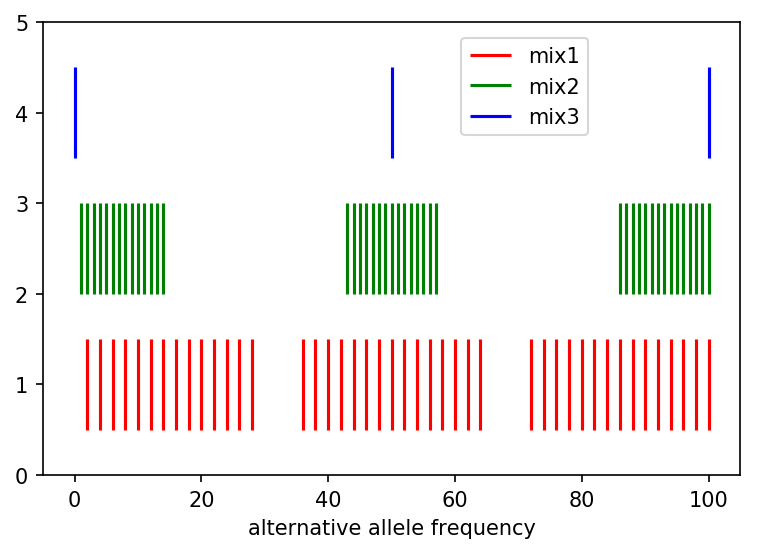

In [19]:
fig, axs = plt.subplots(1, 1)
axs.eventplot(aaf_values['mix1'], lineoffset=1, colors='red', label='mix1')
axs.eventplot(aaf_values['mix2'], lineoffset=2.5, colors='green', label='mix2')
axs.eventplot(aaf_values['mix3'], lineoffset=4, colors='blue', label='mix3')
axs.set_xlabel('alternative allele frequency')
axs.legend(loc=(0.6, 0.75))
axs.set_ylim(0, 5)
attila_utils.savefig(fig, 'possible-vaf-values-mix123')

As mentioned above, `aaf_of_gt` corresponds to the function $f$ of $g$.  Let's create the inverse mapping---from $f$ to $g$---and call it `gt_of_aaf`!

In [13]:
gt_of_aaf = jgc.get_gt_of_aaf(aaf_of_gt)

`gt_of_aaf` is a bit of a misnomer because the function $f$ of $g$ is not invertible.  In other words the reverse mapping is not onto the genotype vectors but to *sets of* those.  Below are the values of `gt_of_aaf` for mix1 and for the 6 lowest and 6 highest alternative allele frequencies.

In [14]:
gt_of_aaf['mix1']

{2: ['1000'],
 4: ['0100', '2000'],
 6: ['1100'],
 8: ['0010', '0200', '2100'],
 10: ['1010', '1200'],
 12: ['0110', '2010', '2200'],
 14: ['1110'],
 16: ['0020', '0210', '2110'],
 18: ['1020', '1210'],
 20: ['0120', '2020', '2210'],
 22: ['1120'],
 24: ['0220', '2120'],
 26: ['1220'],
 28: ['2220'],
 36: ['0001'],
 38: ['1001'],
 40: ['0101', '2001'],
 42: ['1101'],
 44: ['0011', '0201', '2101'],
 46: ['1011', '1201'],
 48: ['0111', '2011', '2201'],
 50: ['1111'],
 52: ['0021', '0211', '2111'],
 54: ['1021', '1211'],
 56: ['0121', '2021', '2211'],
 58: ['1121'],
 60: ['0221', '2121'],
 62: ['1221'],
 64: ['2221'],
 72: ['0002'],
 74: ['1002'],
 76: ['0102', '2002'],
 78: ['1102'],
 80: ['0012', '0202', '2102'],
 82: ['1012', '1202'],
 84: ['0112', '2012', '2202'],
 86: ['1112'],
 88: ['0022', '0212', '2112'],
 90: ['1022', '1212'],
 92: ['0122', '2022', '2212'],
 94: ['1122'],
 96: ['0222', '2122'],
 98: ['1222'],
 100: ['2222']}

Writing `gt_of_aaf` to three files distinguished by the mix they relate to:

In [15]:
[jgc.write_gt_of_aaf(m, gt_of_aaf=gt_of_aaf) for m in aaf_of_gt.columns]

['/home/attila/projects/bsm/results/2019-03-12-prec-recall-design//gt_of_aaf-mix1',
 '/home/attila/projects/bsm/results/2019-03-12-prec-recall-design//gt_of_aaf-mix2',
 '/home/attila/projects/bsm/results/2019-03-12-prec-recall-design//gt_of_aaf-mix3']

## Refinements

### Conditioning on allele frequency

Our DNA mix design results in modeled somatic variants with various alternative frequencies.  Let $V_f \subset V$ be the set of variants whose frequency is $f$.  Then the definitions above can be refined as

$$
\begin{eqnarray}
\text{precision at}\, f &=& p(C, f) = \frac{\mid C \cap V_f\mid}{\mid C\mid} \\
\text{recall at}\, f &=& r(C, f) = \frac{\mid C \cap V_f\mid}{\mid V_f\mid}
\end{eqnarray}
$$


### Overall downsizing  of the set of variants

In our real samples (i.e from the DLPFC) we expect orders of magnitude fewer somatic variants than germline variants.  But in a mixed sample each modeled somatic variant corresponds to a germline variant contained in one or more of the four individuals. This generates a discrepancy: we have orders of magnitude more modeled somatic variants than the expected number of real somatic variants.

### Frequency dependent downsizing

We see (TODO: demonstration) that for our modeled somatic variants the distribution $P$ on the domain of alternative allele frequency $f$ is far from uniform, that is $P(f_1) \neq P(f_2)$.  This means that we may have more (or less) variants at one frequency $f_1$ than another frequency $f_2$; that is: $\mid W_{f_1}\mid \neq \mid W_{f_2}\mid$.  We don't know the frequency distribution for real somatic variants in the DLPFC.  Therefore we may express our ignorance by adjusting the distribution $P(f)$ to some theoretical probability distribution e.g uniform.

### Variants of high allele frequency

Somatic variants of frequency at or near $1/2$ are, in our bulk sequencing setup, indistinguishable from heterozygous germline variants.

### Adjustments

This adjustment can be done by discarding from $W$ a different number of variants at each $f$ under the constraint that 

## Procedures

This section merely sketches the procedures and implementation details, if mentioned at all, are only hinted at.  For implementation see the post

1. germline callsets from our lab `NA12889-chess.vcf`, ..., `NA12892-chess.vcf` and illumina `NA12889-illumina.vcf`, ..., `NA12892-illumina.vcf`
1. take intersections `NA12889-chess.vcf` $\cap$ `NA12889-illumina.vcf` $\rightarrow$ `NA12889.vcf`; likewise obtain `NA12890.vcf`, ...
1. separate `NA12889.vcf` $\rightarrow$ `NA12889-snvs.vcf`, `NA12889-indels.vcf`; the treatment of indels is the same as that of snvs from this point on
1. let $W^{(1)}\equiv$ `NA12889-snps.vcf`, ..., $W^{(4)}\equiv$ `NA12892-snps.vcf`; the notation $W^{(s)}$ makes the point that we consider these sets as the sets of all *variants*, i.e. the biological reality
1. take union $W = \bigcup_{s=1}^4 W^{(s)}$ a.k.a `snps.vcf` and partition according to all possible genotype vector $\{W_g: \; g \in \mathcal{G}\}$ leading to 63 files `snps-1000.vcf`,...,`snps-2222.vcf`
1. apply refinements to $W$ and each $W_g$ in order to arrive at $V$ and each $V_g$, respectively.